<a href="https://colab.research.google.com/github/evinracher/3010090-ontological-engineering/blob/main/week2/workshop/Taller_LangGraph_Completo_Gemini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller: LangGraph para Chatbots Inteligentes (Gemini)
**Objetivo:** practicar desde lo básico hasta memoria y checkpointing (incluye time travel y streaming).  
**Requisitos:** tener `GOOGLE_API_KEY` en Colab Secrets.

Estructura del taller:
1) Tema + ejemplo corto  
2) “Tu turno”: modifica/crea tu propio código  
3) Preguntas teóricas y “¿qué pasa si…?”

In [1]:
%pip install -U langgraph langchain-groq pydantic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.1/158.1 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.5/500.5 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.7/325.7 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.6/212.6 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.0/342.0 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 131.6 MB/s eta 0:00:00


In [2]:

import os
from google.colab import userdata

if not os.getenv("GROQ_API_KEY"):
    try:
        os.environ["GROQ_API_KEY"] = userdata.get("GROQ_API_KEY")
    except Exception:
        pass

print("GROQ_API_KEY:", "✅" if os.getenv("GROQ_API_KEY") else "⚠️")

GROQ_API_KEY: ✅


In [3]:

from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0.2)
print("✅ LLM listo:", llm.model_name)


✅ LLM listo: llama-3.1-8b-instant


In [9]:
# For visualization
from IPython.display import Image, display

## 1) Estados, Nodos y Aristas (los 3 pilares)

### Ejemplo 1: grafo lineal (START → nodo → END)

In [18]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class S1(TypedDict):
    text: str
    upper: str
    lower: str

def to_upper(state: S1):
    return {"upper": state["text"].upper()}

def to_lower(state: S1):
    return {"lower": state["text"].lower()}

g = StateGraph(S1)

# Nodes
g.add_node("to_upper", to_upper)
g.add_node("to_lower", to_lower)

# Edges
g.add_edge(START, "to_upper")
g.add_edge("to_upper", "to_lower")
g.add_edge("to_lower", END)

app1 = g.compile()

app1.invoke({"text": "hola langgraph"})


{'text': 'hola langgraph',
 'upper': 'HOLA LANGGRAPH',
 'lower': 'hola langgraph'}

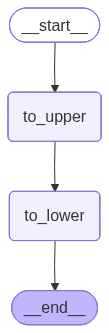

In [12]:
display(Image(app1.get_graph().draw_mermaid_png()))

### Tu turno
1) Crea un nodo `to_lower` que convierta a minúsculas.  
2) Haz un grafo que primero haga `to_upper` y luego `to_lower` (para ver el flujo).

### Preguntas (¿qué pasa si...?)
- ¿Qué pasa si tu estado no tiene la key que el nodo espera?
- ¿Qué pasa si olvidas conectar un nodo a `END`?

## 2) Aristas condicionales (routing)

### Ejemplo 2: decidir ruta según el input

In [ ]:
from typing import Literal

class S2(TypedDict):
    text: str
    kind: str
    out: str

def classify(state: S2):
    t = state["text"].lower()
    kind = "pregunta" if "?" in t else "afirmacion"
    return {"kind": kind}

def responder_pregunta(state: S2):
    resp = llm.invoke(f"Responde breve: {state['text']}")
    return {"out": resp.content}

def resumir_afirmacion(state: S2):
    resp = llm.invoke(f"Resume en 1 frase: {state['text']}")
    return {"out": resp.content}

def route(state: S2) -> Literal["responder_pregunta", "resumir_afirmacion"]:
    return "responder_pregunta" if state["kind"] == "pregunta" else "resumir_afirmacion"

g2 = StateGraph(S2)

g2.add_node("classify", classify)
g2.add_node("responder_pregunta", responder_pregunta)
g2.add_node("resumir_afirmacion", resumir_afirmacion)

g2.add_edge(START, "classify")
g2.add_conditional_edges("classify", route)
g2.add_edge("responder_pregunta", END)
g2.add_edge("resumir_afirmacion", END)

app2 = g2.compile()

print(app2.invoke({"text":"¿Qué es LangGraph?"})["out"])
print(app2.invoke({"text":"LangGraph sirve para orquestar flujos con grafos."})["out"])

### Tu turno
Cambia la regla de routing:
- Si el texto contiene “pasos” → usa un nodo `dar_pasos` (lista 1-3 items).

### Preguntas
- ¿Qué pasa si tu función `route` devuelve un nombre de nodo que no existe?
- ¿Qué pasa si ambos caminos llevan a más nodos y no solo a END?

## 3) Gestión de conversación: historial, truncamiento y resumen

### Ejemplo 3: MessagesState + add_messages

In [ ]:
from langgraph.graph import MessagesState, add_messages
from langchain_core.messages import HumanMessage, AIMessage

# MessagesState ya trae la key "messages" con reducer append-only
def chatbot_node(state: MessagesState):
    resp = llm.invoke(state["messages"])
    return {"messages": [resp]}

g3 = StateGraph(MessagesState)
g3.add_node("chat", chatbot_node)
g3.add_edge(START, "chat")
g3.add_edge("chat", END)
app3 = g3.compile()

state0 = {"messages": [HumanMessage(content="Hola, ¿quién eres?")]}
out = app3.invoke(state0)
out["messages"][-1].content

### Tu turno
- Haz 2 turnos: agrega el mensaje del usuario y vuelve a invocar.
- Observa cómo crece la lista `messages`.
- Implementa una paso para quitar mensajes
- Implementa una paso para resumir mensajes

### Preguntas
- ¿Por qué guardar todo el historial puede ser costoso?
- ¿Qué ventajas tiene “resumir” vs “borrar” mensajes?